In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from math import sqrt
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima.utils import ndiffs
warnings.filterwarnings("ignore")

### 0. Data Preparation

In [2]:
df = pd.read_excel("Online Retail.xlsx", sheet_name="Online Retail")

In [3]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
def generate_time_series(df, period="day"):
    assert period in ["day", "week", "min"]
    mode = '%Y-%m-%U' if period == "week" else '%Y-%m-%d'
    _df = df.copy()
    _df["Income"] = _df["Quantity"] * df["UnitPrice"]
    if period != "min":
        _df['_InvoiceDate'] = _df['InvoiceDate'].dt.strftime(mode)
    else:
        _df['_InvoiceDate'] = _df['InvoiceDate']
    _df = _df[["Income", "_InvoiceDate"]].groupby(by="_InvoiceDate").sum()
    _df = _df.reset_index()
    _df = _df.rename(columns = {'_InvoiceDate':'ds', 'Income':'y'})
    return _df

In [5]:
df_weeks = generate_time_series(df, period="week")
df_days = generate_time_series(df, period="day")
df_min = generate_time_series(df, period="min")

In [6]:
df_weeks_len = len(df_weeks)
df_days_len = len(df_days)
df_min_len = len(df_min)
SPLIT = 0.8

df_weeks_train = df_weeks[:int(SPLIT * df_weeks_len)]
df_weeks_test = df_weeks[int(SPLIT * df_weeks_len):]

df_days_train = df_days[:int(SPLIT * df_days_len)]
df_days_test = df_days[int(SPLIT * df_days_len):]

df_min_train = df_min[:int(SPLIT * df_min_len)]
df_min_test = df_min[int(SPLIT * df_min_len):]

### 1. Prophet

In [7]:
p = Prophet()
p.fit(df_days_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.90424


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       417.998   0.000511738       29.0393   1.069e-05       0.001      120  LS failed, Hessian reset 
      79       418.008   6.10207e-06       50.0312   1.301e-07       0.001      203  LS failed, Hessian reset 
      84       418.009   8.90465e-08       27.9323   1.901e-09       0.001      249  LS failed, Hessian reset 
      85       418.009   3.26901e-08       34.3341      0.8234      0.8234      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [8]:
future = p.make_future_dataframe(periods=len(df_days_test))
forecast = p.predict(future)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


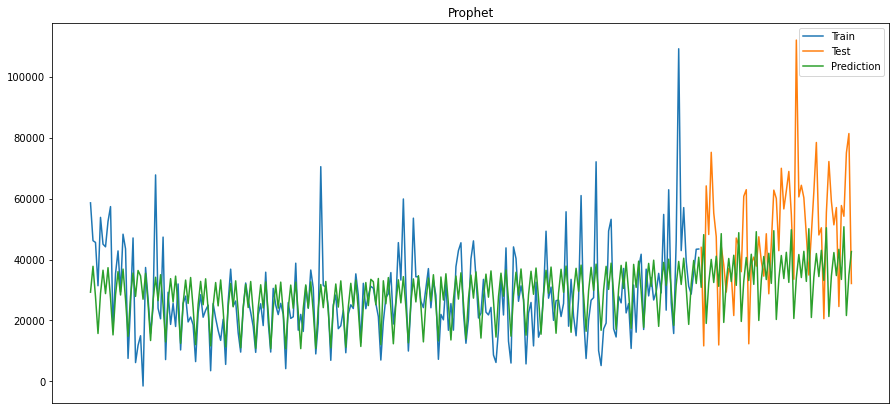

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)
ax.set_title("Prophet")
ax.plot(df_days_train['ds'], df_days_train['y'], label="Train")
ax.plot(df_days_test['ds'], df_days_test['y'], label="Test")
ax.plot(forecast['yhat'], label="Prediction")
ax.legend()
ax.set_xticks([])
plt.show()

In [10]:
prediction = forecast['yhat'][int(SPLIT * df_days_len):]
rms = sqrt(mean_squared_error(df_days_test.y, prediction))
max_income = df_days.y.max()
print(f"RMSE of prediction: {rms:.3f} (or {rms / max_income * 100:.2f} %)")
print(f"Pearson Correlation Coefficient: {pearsonr(df_days_test.y, prediction)[0]:.3f}")

RMSE of prediction: 24662.135 (or 21.99 %)
Pearson Correlation Coefficient: -0.084


### 2. ARIMA

In [11]:
result = adfuller(df_days_train.y.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print(f"ARIMA d={ndiffs(df_days_train.y, test='kpss')}")

ADF Statistic: -3.057050
p-value: 0.029899
ARIMA d=1


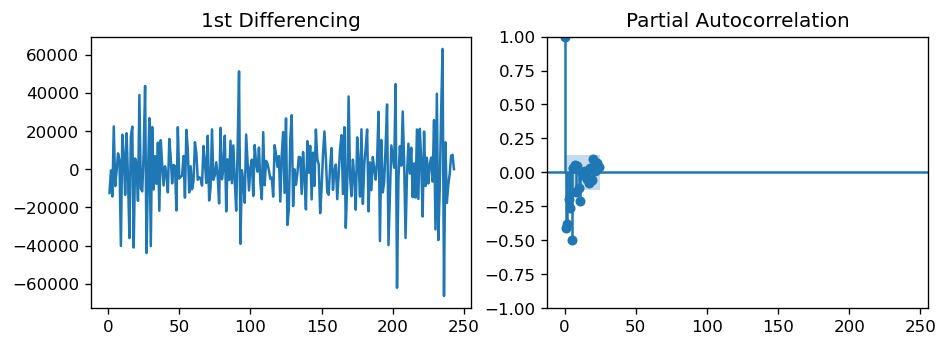

In [12]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_days_train.y.diff()) 
axes[0].set_title('1st Differencing')
plot_pacf(df_days_train.y.diff().dropna(), ax=axes[1])
plt.show()

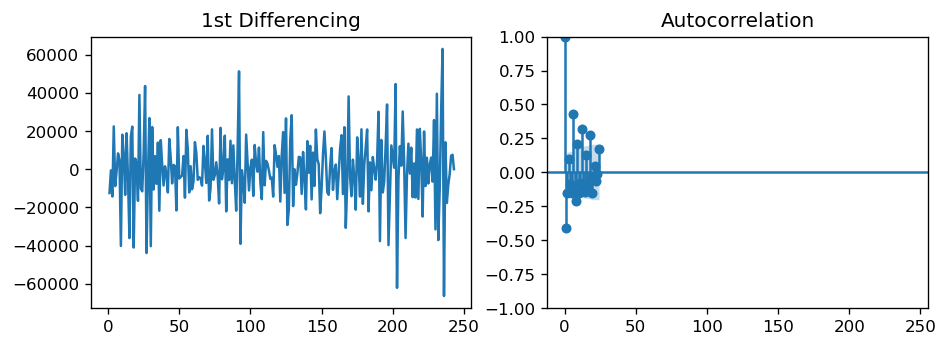

In [13]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_days_train.y.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df_days_train.y.diff().dropna(), ax=axes[1])
plt.show()

In [14]:
model = SARIMAX(df_days_train.y, 
                order = (0, 1, 1), 
                seasonal_order =(2, 1, 1, 30))
  
result = model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.68943D+00    |proj g|=  7.04470D-02


 This problem is unconstrained.



At iterate    5    f=  9.65321D+00    |proj g|=  1.93963D-02

At iterate   10    f=  9.64852D+00    |proj g|=  1.82797D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   2.060D-05   9.649D+00
  F =   9.6485152594651566     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  244
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 30)   Log Likelihood               -2354.238
Date:                            Wed, 27 Apr 2022   AIC                           4718.475
Time:                                    13:44:53   BIC                           4735.282
Sample:                                         0   HQIC                          4725.267
                                            - 244                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8137      0.071    -11.472      0.000      -0.953      -0.675
ar.S.L30      -0.2960      0.427     -0.694      0.488      -1.132       0.540
ar.S.L60      -0.0384      0.275     -0.140      0.889      -0.577       0.501
ma.S.L30      -0.4747      0.444     -1.070      0.285      -1.344       0.395
sigma2      3.571e+08   4.21e-09   8.49e+16      0.000    3.57e+08    3.57e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):               221.44
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                             1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.48e+32. Standard errors may be unstable.
"""

In [15]:
prediction = result.forecast(len(df_days_test), alpha=0.05) 

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

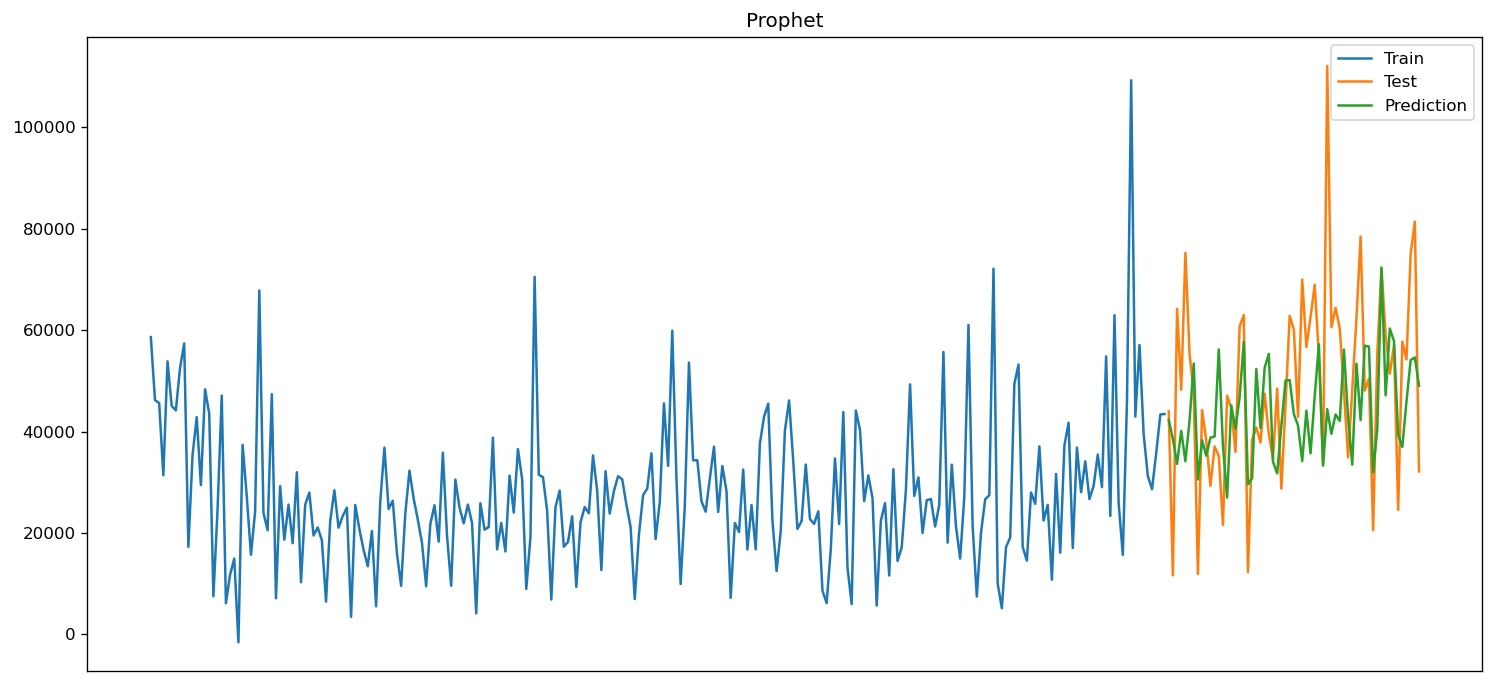

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)
ax.set_title("Prophet")
ax.plot(df_days_train['ds'], df_days_train['y'], label="Train")
ax.plot(df_days_test['ds'], df_days_test['y'], label="Test")
ax.plot(df_days_test['ds'], prediction, label="Prediction")
ax.legend()
ax.set_xticks([])
plt.show()

In [17]:
rms = sqrt(mean_squared_error(df_days_test.y, prediction))
max_income = df_days.y.max()
print(f"RMSE of prediction: {rms:.3f} (or {rms / max_income * 100:.2f} %)")
print(f"Pearson Correlation Coefficient: {pearsonr(df_days_test.y, prediction)[0]:.3f}")

RMSE of prediction: 18178.464 (or 16.21 %)
Pearson Correlation Coefficient: 0.334
